In [1]:
#%tensorflow_version 1.15.x
#Covid-19_NUS_Classifier
import pandas as pd
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Dropout, Dense,Multiply, Dot, Concatenate,Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.models import Sequential, optimizers
#from tensorflow.keras.utils import Sequence, np_utils
from tensorflow.keras.layers import LSTM, Dense, Masking
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tf_slim as slim
import bert
from bert import run_classifier
from bert import optimization
from bert import run_classifier
from bert import tokenization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2.9.1


In [2]:
np.random.seed(1337)

train_raw = pd.read_csv('https://raw.githubusercontent.com/duttaaadhar/Covid-Policy-Tracker/main/final_clean_dataset.csv')
print (train_raw.head())
print (train_raw.shape)

                                              Policy Category  Flag
0   vietnam started reopening schools from 4 may ...        C     2
1     in the coming two weeks university students...        C     1
2    on august 16 the saudi arabian ministry of e...        C     3
3     primary and middle schools and kindergarten...        C     1
4     primary and middle schools in gansu provinc...        C     1
(65776, 3)


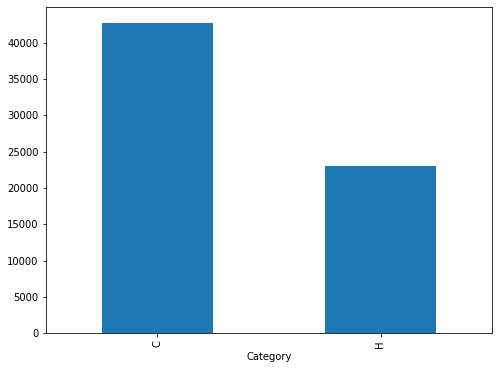

                                              Policy Category
0   vietnam started reopening schools from 4 may ...        C
1     in the coming two weeks university students...        C
2    on august 16 the saudi arabian ministry of e...        C
3     primary and middle schools and kindergarten...        C
4     primary and middle schools in gansu provinc...        C
                                                text label
0   vietnam started reopening schools from 4 may ...     C
1     in the coming two weeks university students...     C
2    on august 16 the saudi arabian ministry of e...     C
3     primary and middle schools and kindergarten...     C
4     primary and middle schools in gansu provinc...     C


In [3]:

fig = plt.figure(figsize=(8,6))
train_raw.groupby('Category').Policy.count().plot.bar(ylim=0)
plt.show()
train_raw = train_raw[['Policy', 'Category']]
train_raw.reset_index(inplace=True, drop=True)
print (train_raw.head())
train_raw=train_raw.rename(columns = {'Policy':'text', 'Category':'label'})
print (train_raw.head())

In [4]:
LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()
len(np.unique(train_raw['label']))
train = train_raw.copy()
train = train.reindex(np.random.permutation(train.index))
print (train.head())

                                                    text  label
40477  on november 10 2020 maryland updated its testi...      1
59438     gansu daily gansu tv station and other trad...      1
11346  the government of bangladesh has made wearing ...      1
33016  public transport is operating the wearing of m...      0
54276  public transportation remains open as per the ...      0


In [5]:
train, val = train_test_split(train, test_size=0.2, random_state=35)
print (train.head())

train.reset_index(drop=True, inplace=True)
print(train.head(2))


val.reset_index(drop=True, inplace=True)
print (val.head(2))

print (val.shape, train.shape)

                                                    text  label
51523  with fewer covid cases being reported and vacc...      0
22888  as of 3 august 2021 in the province of newfoun...      0
54390  the atu makes more than 115 public transport v...      0
56532  internal travels banned from march 21  decreto...      0
58132  in response to the continued severity of covid...      0
                                                text  label
0  with fewer covid cases being reported and vacc...      0
1  as of 3 august 2021 in the province of newfoun...      0
                                                text  label
0  the president of ghana said in his speech on 1...      1
1  effective october 19 2020 the following change...      0
(13156, 2) (52620, 2)


In [6]:
# Set the output directory for saving model file
OUTPUT_DIR = './bert_covid_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.rmtree(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.GFile(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
print (label_list)

***** Model output directory: ./bert_covid_category *****
Training Set Shape : (52620, 2)
Validation Set Shape : (13156, 2)
[0, 1]


In [7]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else:
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [8]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()


val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,the president of ghana said in his speech on 1...,1,[the president of ghana said in his speech on ...
1,effective october 19 2020 the following change...,0,[effective october 19 2020 the following chang...


In [9]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(53314, 53314, 53314)

In [10]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(13352, 13352, 13352)

In [11]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
print (train_df.head())
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
print (val_df.head())

                                                text  label
0  with fewer covid cases being reported and vacc...      0
1  as of 3 august 2021 in the province of newfoun...      0
2  the atu makes more than 115 public transport v...      0
3  internal travels banned from march 21 decreto ...      0
4  in response to the continued severity of covid...      0
                                                text  label
0  the president of ghana said in his speech on 1...      1
1  effective october 19 2020 the following change...      0
2  according to unesco the schools are partially ...      0
3  in addendum 1 to amended and restated executiv...      0
4  on 26 january 2020 the state drug administrati...      1


In [12]:
# Set the output directory for saving model file
OUTPUT_DIR = './bert_covid_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.deleterecursively(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: ./bert_covid_category *****


In [24]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (52620, 3)
Validation Set Shape : (13156, 3)


In [25]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1]

In [26]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [27]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,with fewer covid cases being reported and vacc...,0,[with fewer covid cases being reported and vac...
1,as of 3 august 2021 in the province of newfoun...,0,[as of 3 august 2021 in the province of newfou...
2,the atu makes more than 115 public transport v...,0,[the atu makes more than 115 public transport ...
3,internal travels banned from march 21 decreto...,0,[internal travels banned from march 21 decreto...
4,in response to the continued severity of covid...,0,[in response to the continued severity of covi...


In [28]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,the president of ghana said in his speech on 1...,1,[the president of ghana said in his speech on ...
1,effective october 19 2020 the following change...,0,[effective october 19 2020 the following chang...


In [29]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)


(53314, 53314, 53314)

In [30]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(13352, 13352, 13352)

In [31]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,with fewer covid cases being reported and vacc...,0
1,as of 3 august 2021 in the province of newfoun...,0
2,the atu makes more than 115 public transport v...,0
3,internal travels banned from march 21 decreto ...,0
4,in response to the continued severity of covid...,0


In [32]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,the president of ghana said in his speech on 1...,1
1,effective october 19 2020 the following change...,0
2,according to unesco the schools are partially ...,0
3,in addendum 1 to amended and restated executiv...,0
4,on 26 january 2020 the state drug administrati...,1


In [33]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [34]:
train_InputExamples

0        <bert.run_classifier.InputExample object at 0x...
1        <bert.run_classifier.InputExample object at 0x...
2        <bert.run_classifier.InputExample object at 0x...
3        <bert.run_classifier.InputExample object at 0x...
4        <bert.run_classifier.InputExample object at 0x...
                               ...                        
53309    <bert.run_classifier.InputExample object at 0x...
53310    <bert.run_classifier.InputExample object at 0x...
53311    <bert.run_classifier.InputExample object at 0x...
53312    <bert.run_classifier.InputExample object at 0x...
53313    <bert.run_classifier.InputExample object at 0x...
Length: 53314, dtype: object

In [35]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None


Row 0 - text_a of training set :  with fewer covid cases being reported and vaccine distribution underway restrictions on youth and adult sports in st louis county were eased feb 16 the move also allows for tournament play at all levels of play for kids and grownups the county is also allowing play for tournaments with single competition games some restrictions regarding spectator size masks and social distancing are still in place


Row 0 - text_b of training set :  None


Row 0 - label of training set :  0


In [36]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session(config=config) as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [37]:
len(tokenizer.vocab.keys())

30522

In [38]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['with', 'fewer', 'co', '##vid', 'cases', 'being', 'reported', 'and', 'vaccine', 'distribution', 'underway', 'restrictions', 'on', 'youth', 'and', 'adult', 'sports', 'in', 'st', 'louis', 'county', 'were', 'eased', 'feb', '16', 'the', 'move', 'also', 'allows', 'for', 'tournament', 'play', 'at', 'all', 'levels', 'of', 'play', 'for', 'kids', 'and', 'grown', '##ups', 'the', 'county', 'is', 'also', 'allowing', 'play', 'for', 'tournaments', 'with', 'single', 'competition', 'games', 'some', 'restrictions', 'regarding', 'spectator', 'size', 'masks', 'and', 'social', 'di', '##stan', '##cing', 'are', 'still', 'in', 'place']


In [39]:
MAX_SEQ_LENGTH = 200
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 53314


INFO:tensorflow:Writing example 0 of 53314


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] with fewer co ##vid cases being reported and vaccine distribution underway restrictions on youth and adult sports in st louis county were eased feb 16 the move also allows for tournament play at all levels of play for kids and grown ##ups the county is also allowing play for tournaments with single competition games some restrictions regarding spectator size masks and social di ##stan ##cing are still in place [SEP]


INFO:tensorflow:tokens: [CLS] with fewer co ##vid cases being reported and vaccine distribution underway restrictions on youth and adult sports in st louis county were eased feb 16 the move also allows for tournament play at all levels of play for kids and grown ##ups the county is also allowing play for tournaments with single competition games some restrictions regarding spectator size masks and social di ##stan ##cing are still in place [SEP]


INFO:tensorflow:input_ids: 101 2007 8491 2522 17258 3572 2108 2988 1998 17404 4353 14128 9259 2006 3360 1998 4639 2998 1999 2358 3434 2221 2020 10987 13114 2385 1996 2693 2036 4473 2005 2977 2377 2012 2035 3798 1997 2377 2005 4268 1998 4961 22264 1996 2221 2003 2036 4352 2377 2005 8504 2007 2309 2971 2399 2070 9259 4953 21027 2946 15806 1998 2591 4487 12693 6129 2024 2145 1999 2173 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2007 8491 2522 17258 3572 2108 2988 1998 17404 4353 14128 9259 2006 3360 1998 4639 2998 1999 2358 3434 2221 2020 10987 13114 2385 1996 2693 2036 4473 2005 2977 2377 2012 2035 3798 1997 2377 2005 4268 1998 4961 22264 1996 2221 2003 2036 4352 2377 2005 8504 2007 2309 2971 2399 2070 9259 4953 21027 2946 15806 1998 2591 4487 12693 6129 2024 2145 1999 2173 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] as of 3 august 2021 in the province of newfoundland and labrador nl bus transit riders ##hip is still restricted below capacity however limits are higher now that nl is at a less serious alert level no rules different ##iating between riders based on va ##cci ##nation status see st johns and corner brook nl websites archived [SEP]


INFO:tensorflow:tokens: [CLS] as of 3 august 2021 in the province of newfoundland and labrador nl bus transit riders ##hip is still restricted below capacity however limits are higher now that nl is at a less serious alert level no rules different ##iating between riders based on va ##cci ##nation status see st johns and corner brook nl websites archived [SEP]


INFO:tensorflow:input_ids: 101 2004 1997 1017 2257 25682 1999 1996 2874 1997 11944 1998 18604 17953 3902 6671 8195 5605 2003 2145 7775 2917 3977 2174 6537 2024 3020 2085 2008 17953 2003 2012 1037 2625 3809 9499 2504 2053 3513 2367 15370 2090 8195 2241 2006 12436 14693 9323 3570 2156 2358 11545 1998 3420 9566 17953 11744 9749 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2004 1997 1017 2257 25682 1999 1996 2874 1997 11944 1998 18604 17953 3902 6671 8195 5605 2003 2145 7775 2917 3977 2174 6537 2024 3020 2085 2008 17953 2003 2012 1037 2625 3809 9499 2504 2053 3513 2367 15370 2090 8195 2241 2006 12436 14693 9323 3570 2156 2358 11545 1998 3420 9566 17953 11744 9749 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the at ##u makes more than 115 public transport vehicles available to meet the demand for travel on the metropolitan feeder routes due to the decision of the concession ##aire ##s to suspend their operation it appears most public transport is restored to regular schedules pre ##co ##vid thus code change from 2 ##t to 1 ##t link [SEP]


INFO:tensorflow:tokens: [CLS] the at ##u makes more than 115 public transport vehicles available to meet the demand for travel on the metropolitan feeder routes due to the decision of the concession ##aire ##s to suspend their operation it appears most public transport is restored to regular schedules pre ##co ##vid thus code change from 2 ##t to 1 ##t link [SEP]


INFO:tensorflow:input_ids: 101 1996 2012 2226 3084 2062 2084 10630 2270 3665 4683 2800 2000 3113 1996 5157 2005 3604 2006 1996 4956 21429 5847 2349 2000 1996 3247 1997 1996 16427 14737 2015 2000 28324 2037 3169 2009 3544 2087 2270 3665 2003 5854 2000 3180 20283 3653 3597 17258 2947 3642 2689 2013 1016 2102 2000 1015 2102 4957 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 2012 2226 3084 2062 2084 10630 2270 3665 4683 2800 2000 3113 1996 5157 2005 3604 2006 1996 4956 21429 5847 2349 2000 1996 3247 1997 1996 16427 14737 2015 2000 28324 2037 3169 2009 3544 2087 2270 3665 2003 5854 2000 3180 20283 3653 3597 17258 2947 3642 2689 2013 1016 2102 2000 1015 2102 4957 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] internal travels banned from march 21 dec ##ret ##o su ##pre ##mo n 41 ##9 ##6 link b a part ##ir de las ce ##ro 0 ho ##ras del da sb ##ado 21 de mar ##zo de 2020 se suspend ##e el transport ##e terre ##st ##re flu ##vial y lac ##ust ##re de pas ##aj ##eros internacional inter ##de ##par ##tam ##ental e inter ##pro ##vin ##cial [SEP]


INFO:tensorflow:tokens: [CLS] internal travels banned from march 21 dec ##ret ##o su ##pre ##mo n 41 ##9 ##6 link b a part ##ir de las ce ##ro 0 ho ##ras del da sb ##ado 21 de mar ##zo de 2020 se suspend ##e el transport ##e terre ##st ##re flu ##vial y lac ##ust ##re de pas ##aj ##eros internacional inter ##de ##par ##tam ##ental e inter ##pro ##vin ##cial [SEP]


INFO:tensorflow:input_ids: 101 4722 7930 7917 2013 2233 2538 11703 13465 2080 10514 28139 5302 1050 4601 2683 2575 4957 1038 1037 2112 4313 2139 5869 8292 3217 1014 7570 8180 3972 4830 24829 9365 2538 2139 9388 6844 2139 12609 7367 28324 2063 3449 3665 2063 25170 3367 2890 19857 18660 1061 18749 19966 2890 2139 14674 13006 27360 27607 6970 3207 19362 15464 21050 1041 6970 21572 6371 13247 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4722 7930 7917 2013 2233 2538 11703 13465 2080 10514 28139 5302 1050 4601 2683 2575 4957 1038 1037 2112 4313 2139 5869 8292 3217 1014 7570 8180 3972 4830 24829 9365 2538 2139 9388 6844 2139 12609 7367 28324 2063 3449 3665 2063 25170 3367 2890 19857 18660 1061 18749 19966 2890 2139 14674 13006 27360 27607 6970 3207 19362 15464 21050 1041 6970 21572 6371 13247 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] in response to the continued severity of co ##vid ##19 and the new corona ##virus strain found in brazil travelers who have history of travel to brazil in the past 14 days will be required to undergo qu ##aran ##tine at group qu ##aran ##tine facilities after arrival in taiwan starting february 24 2021 [SEP]


INFO:tensorflow:tokens: [CLS] in response to the continued severity of co ##vid ##19 and the new corona ##virus strain found in brazil travelers who have history of travel to brazil in the past 14 days will be required to undergo qu ##aran ##tine at group qu ##aran ##tine facilities after arrival in taiwan starting february 24 2021 [SEP]


INFO:tensorflow:input_ids: 101 1999 3433 2000 1996 2506 18976 1997 2522 17258 16147 1998 1996 2047 21887 23350 10178 2179 1999 4380 15183 2040 2031 2381 1997 3604 2000 4380 1999 1996 2627 2403 2420 2097 2022 3223 2000 13595 24209 20486 10196 2012 2177 24209 20486 10196 4128 2044 5508 1999 6629 3225 2337 2484 25682 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1999 3433 2000 1996 2506 18976 1997 2522 17258 16147 1998 1996 2047 21887 23350 10178 2179 1999 4380 15183 2040 2031 2381 1997 3604 2000 4380 1999 1996 2627 2403 2420 2097 2022 3223 2000 13595 24209 20486 10196 2012 2177 24209 20486 10196 4128 2044 5508 1999 6629 3225 2337 2484 25682 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 53314


INFO:tensorflow:Writing example 10000 of 53314


INFO:tensorflow:Writing example 20000 of 53314


INFO:tensorflow:Writing example 20000 of 53314


INFO:tensorflow:Writing example 30000 of 53314


INFO:tensorflow:Writing example 30000 of 53314


INFO:tensorflow:Writing example 40000 of 53314


INFO:tensorflow:Writing example 40000 of 53314


INFO:tensorflow:Writing example 50000 of 53314


INFO:tensorflow:Writing example 50000 of 53314


INFO:tensorflow:Writing example 0 of 13352


INFO:tensorflow:Writing example 0 of 13352


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the president of ghana said in his speech on 14 june that the wearing of masks is now mandatory leaving our homes without a face mask or face covering on is an offence the police have been instructed to enforce this directive which is the subject of an executive instrument [SEP]


INFO:tensorflow:tokens: [CLS] the president of ghana said in his speech on 14 june that the wearing of masks is now mandatory leaving our homes without a face mask or face covering on is an offence the police have been instructed to enforce this directive which is the subject of an executive instrument [SEP]


INFO:tensorflow:input_ids: 101 1996 2343 1997 9701 2056 1999 2010 4613 2006 2403 2238 2008 1996 4147 1997 15806 2003 2085 10915 2975 2256 5014 2302 1037 2227 7308 2030 2227 5266 2006 2003 2019 15226 1996 2610 2031 2042 10290 2000 16306 2023 16449 2029 2003 1996 3395 1997 2019 3237 6602 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 2343 1997 9701 2056 1999 2010 4613 2006 2403 2238 2008 1996 4147 1997 15806 2003 2085 10915 2975 2256 5014 2302 1037 2227 7308 2030 2227 5266 2006 2003 2019 15226 1996 2610 2031 2042 10290 2000 16306 2023 16449 2029 2003 1996 3395 1997 2019 3237 6602 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] effective october 19 2020 the following changes to service and operations have been made to protect the health and safety of essential workers who rely on public transit as well as our front ##line staff service levels prior ##iti ##ze certain routes to meet riders ##hip demand avoid crowd ##ing on vehicles and to allow for physical di ##stan ##cing in keeping with health and safety protocol guidance shared trips on the ride have been eliminated ride customers can still bring a personal care attendant or guest on their trip riders are still recommended ##urg ##ed to stay home if sick coded 1 ##t as the mb ##ta refers to public transportation in the bay area of ma website [SEP]


INFO:tensorflow:tokens: [CLS] effective october 19 2020 the following changes to service and operations have been made to protect the health and safety of essential workers who rely on public transit as well as our front ##line staff service levels prior ##iti ##ze certain routes to meet riders ##hip demand avoid crowd ##ing on vehicles and to allow for physical di ##stan ##cing in keeping with health and safety protocol guidance shared trips on the ride have been eliminated ride customers can still bring a personal care attendant or guest on their trip riders are still recommended ##urg ##ed to stay home if sick coded 1 ##t as the mb ##ta refers to public transportation in the bay area of ma website [SEP]


INFO:tensorflow:input_ids: 101 4621 2255 2539 12609 1996 2206 3431 2000 2326 1998 3136 2031 2042 2081 2000 4047 1996 2740 1998 3808 1997 6827 3667 2040 11160 2006 2270 6671 2004 2092 2004 2256 2392 4179 3095 2326 3798 3188 25090 4371 3056 5847 2000 3113 8195 5605 5157 4468 4306 2075 2006 4683 1998 2000 3499 2005 3558 4487 12693 6129 1999 4363 2007 2740 1998 3808 8778 8606 4207 9109 2006 1996 4536 2031 2042 5892 4536 6304 2064 2145 3288 1037 3167 2729 16742 2030 4113 2006 2037 4440 8195 2024 2145 6749 12514 2098 2000 2994 2188 2065 5305 22402 1015 2102 2004 1996 16914 2696 5218 2000 2270 5193 1999 1996 3016 2181 1997 5003 4037 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4621 2255 2539 12609 1996 2206 3431 2000 2326 1998 3136 2031 2042 2081 2000 4047 1996 2740 1998 3808 1997 6827 3667 2040 11160 2006 2270 6671 2004 2092 2004 2256 2392 4179 3095 2326 3798 3188 25090 4371 3056 5847 2000 3113 8195 5605 5157 4468 4306 2075 2006 4683 1998 2000 3499 2005 3558 4487 12693 6129 1999 4363 2007 2740 1998 3808 8778 8606 4207 9109 2006 1996 4536 2031 2042 5892 4536 6304 2064 2145 3288 1037 3167 2729 16742 2030 4113 2006 2037 4440 8195 2024 2145 6749 12514 2098 2000 2994 2188 2065 5305 22402 1015 2102 2004 1996 16914 2696 5218 2000 2270 5193 1999 1996 3016 2181 1997 5003 4037 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] according to unesco the schools are partially open in the case the high schools are open please see [SEP]


INFO:tensorflow:tokens: [CLS] according to unesco the schools are partially open in the case the high schools are open please see [SEP]


INFO:tensorflow:input_ids: 101 2429 2000 12239 1996 2816 2024 6822 2330 1999 1996 2553 1996 2152 2816 2024 2330 3531 2156 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2429 2000 12239 1996 2816 2024 6822 2330 1999 1996 2553 1996 2152 2816 2024 2330 3531 2156 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] in add ##end ##um 1 to amended and rest ##ated executive order 01 ##20 governor phil scott ordered that the state of emergency for the state of vermont shall be extended through midnight on august 15 2020 the amended and rest ##ated executive order issued june 15 2020 and all directive ##s issued there ##under shall continue in full force and effect until then therefore fairs and festivals remain cancelled however this shall not prevent fair ##grounds and other indoor and outdoor venues from operating for sporting entertainment concerts and other events in accordance with then applicable v ##dha ##cc ##d guidance on gathering size o ##cc ##up ##ancy limits di ##stan ##cing and other health and safety requirements add ##end ##um 1 to amended and rest ##ated executive order 01 ##20 [SEP]


INFO:tensorflow:tokens: [CLS] in add ##end ##um 1 to amended and rest ##ated executive order 01 ##20 governor phil scott ordered that the state of emergency for the state of vermont shall be extended through midnight on august 15 2020 the amended and rest ##ated executive order issued june 15 2020 and all directive ##s issued there ##under shall continue in full force and effect until then therefore fairs and festivals remain cancelled however this shall not prevent fair ##grounds and other indoor and outdoor venues from operating for sporting entertainment concerts and other events in accordance with then applicable v ##dha ##cc ##d guidance on gathering size o ##cc ##up ##ancy limits di ##stan ##cing and other health and safety requirements add ##end ##um 1 to amended and rest ##ated executive order 01 ##20 [SEP]


INFO:tensorflow:input_ids: 101 1999 5587 10497 2819 1015 2000 13266 1998 2717 4383 3237 2344 5890 11387 3099 6316 3660 3641 2008 1996 2110 1997 5057 2005 1996 2110 1997 8839 4618 2022 3668 2083 7090 2006 2257 2321 12609 1996 13266 1998 2717 4383 3237 2344 3843 2238 2321 12609 1998 2035 16449 2015 3843 2045 20824 4618 3613 1999 2440 2486 1998 3466 2127 2059 3568 21947 1998 7519 3961 8014 2174 2023 4618 2025 4652 4189 28951 1998 2060 7169 1998 7254 9356 2013 4082 2005 7419 4024 6759 1998 2060 2824 1999 10388 2007 2059 12711 1058 17516 9468 2094 8606 2006 7215 2946 1051 9468 6279 11656 6537 4487 12693 6129 1998 2060 2740 1998 3808 5918 5587 10497 2819 1015 2000 13266 1998 2717 4383 3237 2344 5890 11387 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1999 5587 10497 2819 1015 2000 13266 1998 2717 4383 3237 2344 5890 11387 3099 6316 3660 3641 2008 1996 2110 1997 5057 2005 1996 2110 1997 8839 4618 2022 3668 2083 7090 2006 2257 2321 12609 1996 13266 1998 2717 4383 3237 2344 3843 2238 2321 12609 1998 2035 16449 2015 3843 2045 20824 4618 3613 1999 2440 2486 1998 3466 2127 2059 3568 21947 1998 7519 3961 8014 2174 2023 4618 2025 4652 4189 28951 1998 2060 7169 1998 7254 9356 2013 4082 2005 7419 4024 6759 1998 2060 2824 1999 10388 2007 2059 12711 1058 17516 9468 2094 8606 2006 7215 2946 1051 9468 6279 11656 6537 4487 12693 6129 1998 2060 2740 1998 3808 5918 5587 10497 2819 1015 2000 13266 1998 2717 4383 3237 2344 5890 11387 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] on 26 january 2020 the state drug administration of china approved four co ##vid ##19 testing products 21 january 2020 saw the first case of new corona ##virus disease infection in henan province which was tested for nuclei ##c acid in specimens by the henan cdc since then henan province has implemented nuclei ##c acid testing of key populations such as infected persons close contacts of infected persons and persons arriving in henan from wu ##han link [SEP]


INFO:tensorflow:tokens: [CLS] on 26 january 2020 the state drug administration of china approved four co ##vid ##19 testing products 21 january 2020 saw the first case of new corona ##virus disease infection in henan province which was tested for nuclei ##c acid in specimens by the henan cdc since then henan province has implemented nuclei ##c acid testing of key populations such as infected persons close contacts of infected persons and persons arriving in henan from wu ##han link [SEP]


INFO:tensorflow:input_ids: 101 2006 2656 2254 12609 1996 2110 4319 3447 1997 2859 4844 2176 2522 17258 16147 5604 3688 2538 2254 12609 2387 1996 2034 2553 1997 2047 21887 23350 4295 8985 1999 27837 2874 2029 2001 7718 2005 23767 2278 5648 1999 9908 2011 1996 27837 26629 2144 2059 27837 2874 2038 7528 23767 2278 5648 5604 1997 3145 7080 2107 2004 10372 5381 2485 10402 1997 10372 5381 1998 5381 7194 1999 27837 2013 8814 4819 4957 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2006 2656 2254 12609 1996 2110 4319 3447 1997 2859 4844 2176 2522 17258 16147 5604 3688 2538 2254 12609 2387 1996 2034 2553 1997 2047 21887 23350 4295 8985 1999 27837 2874 2029 2001 7718 2005 23767 2278 5648 1999 9908 2011 1996 27837 26629 2144 2059 27837 2874 2038 7528 23767 2278 5648 5604 1997 3145 7080 2107 2004 10372 5381 2485 10402 1997 10372 5381 1998 5381 7194 1999 27837 2013 8814 4819 4957 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 13352


INFO:tensorflow:Writing example 10000 of 13352


In [40]:
#Example on first observation in the training set
print("Sentence - ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens - ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("InputIDs - ", train_features[0].input_ids)
print("-"*30)
print("InputMasks - ", train_features[0].input_mask)
print("-"*30)
print("SegmentIDs - ", train_features[0].segment_ids)

Sentence -  with fewer covid cases being reported and vaccine distribution underway restrictions on youth and adult sports in st louis county were eased feb 16 the move also allows for tournament play at all levels of play for kids and grownups the county is also allowing play for tournaments with single competition games some restrictions regarding spectator size masks and social distancing are still in place
------------------------------
Tokens -  ['with', 'fewer', 'co', '##vid', 'cases', 'being', 'reported', 'and', 'vaccine', 'distribution', 'underway', 'restrictions', 'on', 'youth', 'and', 'adult', 'sports', 'in', 'st', 'louis', 'county', 'were', 'eased', 'feb', '16', 'the', 'move', 'also', 'allows', 'for', 'tournament', 'play', 'at', 'all', 'levels', 'of', 'play', 'for', 'kids', 'and', 'grown', '##ups', 'the', 'county', 'is', 'also', 'allowing', 'play', 'for', 'tournaments', 'with', 'single', 'competition', 'games', 'some', 'restrictions', 'regarding', 'spectator', 'size', 'masks

In [41]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [42]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [43]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [44]:
num_train_steps, len(label_list)

(3332, 2)

In [45]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': './bert_covid_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './bert_covid_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [46]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [47]:
#Training the model


print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into ./bert_covid_category\model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./bert_covid_category\model.ckpt.


NotFoundError: Graph execution error:

Detected at node 'save_2/SaveV2' defined at (most recent call last):
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dutta\AppData\Local\Temp\ipykernel_16224\1278425444.py", line 6, in <module>
      estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 360, in train
      loss = self._train_model(input_fn, hooks, saving_listeners)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1186, in _train_model
      return self._train_model_default(input_fn, hooks, saving_listeners)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1219, in _train_model_default
      saving_listeners)
    File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1525, in _train_with_estimator_spec
      save_graph_def=self._config.checkpoint_save_graph_def) as mon_sess:
Node: 'save_2/SaveV2'
Failed to create a NewWriteableFile: ./bert_covid_category\model.ckpt-0_temp\part-00000-of-00001.data-00000-of-00001.tempstate8100376870611183379 : The system cannot find the path specified.
; No such process
	 [[{{node save_2/SaveV2}}]]

Original stack trace for 'save_2/SaveV2':
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\asyncio\base_events.py", line 541, in run_forever
    self._run_once()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\asyncio\base_events.py", line 1786, in _run_once
    handle._run()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
    await self.process_one()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
    await dispatch(*args)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
    await result
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
    reply_content = await reply_content
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
    return runner(coro)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dutta\AppData\Local\Temp\ipykernel_16224\1278425444.py", line 6, in <module>
    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 360, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1186, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1219, in _train_model_default
    saving_listeners)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow_estimator\python\estimator\estimator.py", line 1525, in _train_with_estimator_spec
    save_graph_def=self._config.checkpoint_save_graph_def) as mon_sess:
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 612, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 1058, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 757, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 1263, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 1268, in _create_session
    return self._sess_creator.create_session()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 910, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 668, in create_session
    self._scaffold.finalize()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\monitored_session.py", line 240, in finalize
    self._saver.build()
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 945, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 983, in _build
    build_restore=build_restore)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 535, in _build_internal
    save_tensor = self._AddShardedSaveOps(filename_tensor, per_device)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 327, in _AddShardedSaveOps
    return self._AddShardedSaveOpsForV2(filename_tensor, per_device)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 301, in _AddShardedSaveOpsForV2
    sharded_saves.append(self._AddSaveOps(sharded_filename, saveables))
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 233, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\training\saver.py", line 149, in save_op
    tensors)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1715, in save_v2
    name=name)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 799, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\framework\ops.py", line 3762, in _create_op_internal
    op_def=op_def)
  File "C:\Users\dutta\.conda\envs\nuscovpol\lib\site-packages\tensorflow\python\framework\ops.py", line 2133, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [48]:
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Could not find trained model in model_dir: ./bert_covid_category, running initialization to evaluate.


INFO:tensorflow:Could not find trained model in model_dir: ./bert_covid_category, running initialization to evaluate.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2022-07-14T00:38:11


INFO:tensorflow:Starting evaluation at 2022-07-14T00:38:11


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3419.05885s


INFO:tensorflow:Inference Time : 3419.05885s


INFO:tensorflow:Finished evaluation at 2022-07-14-01:35:11


INFO:tensorflow:Finished evaluation at 2022-07-14-01:35:11


INFO:tensorflow:Saving dict for global step 0: eval_accuracy = 0.39784303, false_negatives = 655.0, false_positives = 7385.0, global_step = 0, loss = 0.74829954, true_negatives = 1281.0, true_positives = 4031.0


INFO:tensorflow:Saving dict for global step 0: eval_accuracy = 0.39784303, false_negatives = 655.0, false_positives = 7385.0, global_step = 0, loss = 0.74829954, true_negatives = 1281.0, true_positives = 4031.0


{'eval_accuracy': 0.39784303,
 'false_negatives': 655.0,
 'false_positives': 7385.0,
 'loss': 0.74829954,
 'true_negatives': 1281.0,
 'true_positives': 4031.0,
 'global_step': 0}

In [55]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])
    print("\n Predictions:")
    print(len(predictions))

    for p in predictions:
        print(int(p['labels'][0]))

In [62]:
in_sentences="On May 30th, mask were made compulsory"
estimator.getPrediction(in_sentences)

AttributeError: 'Estimator' object has no attribute 'getPrediction'

In [61]:
in_sentences="On May 30th, mask were made compulsory"
input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences]
input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
predictionss = list(estimator.predict(predict_input_fn))
print("\n Predictions:")
print(len(predictions))

for p in predictions:
    print(int(p['labels'][0]))

INFO:tensorflow:Writing example 0 of 38


INFO:tensorflow:Writing example 0 of 38


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] o [SEP]


INFO:tensorflow:tokens: [CLS] o [SEP]


INFO:tensorflow:input_ids: 101 1051 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1051 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] n [SEP]


INFO:tensorflow:tokens: [CLS] n [SEP]


INFO:tensorflow:input_ids: 101 1050 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1050 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] [SEP]


INFO:tensorflow:tokens: [CLS] [SEP]


INFO:tensorflow:input_ids: 101 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] m [SEP]


INFO:tensorflow:tokens: [CLS] m [SEP]


INFO:tensorflow:input_ids: 101 1049 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1049 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] a [SEP]


INFO:tensorflow:tokens: [CLS] a [SEP]


INFO:tensorflow:input_ids: 101 1037 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1037 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Could not find trained model in model_dir: ./bert_covid_category, running initialization to predict.


INFO:tensorflow:Could not find trained model in model_dir: ./bert_covid_category, running initialization to predict.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.



 Predictions:


NameError: name 'predictions' is not defined

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape

((53314, 2), (13352, 2))

In [ ]:

tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))

In [ ]:
val_emb.shape, tr_emb.shape

((13352, 768), (53314, 768))

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

52620

In [ ]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.85904723, 0.39365005, -0.90690464, 0.5479...",0
1,"[[-0.77347225, 0.51095533, 0.43423423, -0.1979...",0
2,"[[-0.74381185, 0.5202323, 0.19062304, -0.15391...",0
3,"[[-0.75183046, 0.52026623, 0.39197132, -0.2274...",0
4,"[[-0.8768441, 0.50662225, -0.88567513, 0.68374...",0


In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()


,emb,label
0,"[[0.89039195, -0.10914725, -0.9989741, 0.36552...",1
1,"[[-0.86179864, 0.5073718, -0.8147896, 0.495353...",0
2,"[[-0.687864, 0.42036554, 0.6924942, -0.41502, ...",0
3,"[[-0.93091357, 0.39514002, -0.91385025, 0.8209...",0
4,"[[0.51623607, -0.2874055, -0.5702115, 0.418609...",1


In [ ]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)


In [ ]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_3 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 62        
Total params: 350,692
Trainable params: 350,692
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((52620, 2), (7893, 2), (5263, 2))

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 3
batches_per_epoch =  4571
print (batch_size * batches_per_epoch)
print (num_sequences)
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

13713
52620


In [ ]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 11
batches_per_epoch_val = 187
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )


Epoch 1/10
4571/4571 [==============================] - 28s 6ms/step - loss: 0.0710 - acc: 0.9786 - val_loss: 0.0043 - val_acc: 0.9616
Epoch 2/10
4571/4571 [==============================] - 27s 6ms/step - loss: 0.0672 - acc: 0.9789 - val_loss: 0.0060 - val_acc: 0.9631
Epoch 3/10
4571/4571 [==============================] - 29s 6ms/step - loss: 0.0661 - acc: 0.9790 - val_loss: 0.0047 - val_acc: 0.9616
Epoch 4/10
4571/4571 [==============================] - 27s 6ms/step - loss: 0.0654 - acc: 0.9789 - val_loss: 0.0023 - val_acc: 0.9621

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 5/10
4571/4571 [==============================] - 28s 6ms/step - loss: 0.0656 - acc: 0.9790 - val_loss: 0.0045 - val_acc: 0.9616
Epoch 6/10
4571/4571 [==============================] - 27s 6ms/step - loss: 0.0653 - acc: 0.9790 - val_loss: 0.0050 - val_acc: 0.9606
Epoch 7/10
4571/4571 [==============================] - 28s 6ms/step - loss: 0.0653 - acc: 0.9790 - val_loss:

In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 343
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.001198482932522893, 0.975218653678894]